In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
random_state = 42

# Load the Diabetes dataset
diabetes_data = load_diabetes()
X = pd.DataFrame(diabetes_data.data, columns=diabetes_data.feature_names)
y = diabetes_data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


In [3]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [4]:
# Standardizing features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Create and fit the Random Forest Regressor model
model = LinearRegression()
model.fit(X_train_standardized, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_standardized)

In [5]:
# Calculate R-squared value
r2 = r2_score(y_test, y_pred)
r2

0.45260276297191915

In [6]:
# Retrieve the coefficients and feature names
coefficients = model.coef_
feature_names = diabetes_data.feature_names

# Create a DataFrame to store the coefficients with their corresponding feature names
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient magnitude in descending order
coeff_df = coeff_df.reindex(coeff_df['Coefficient'].abs().sort_values(ascending=False).index)


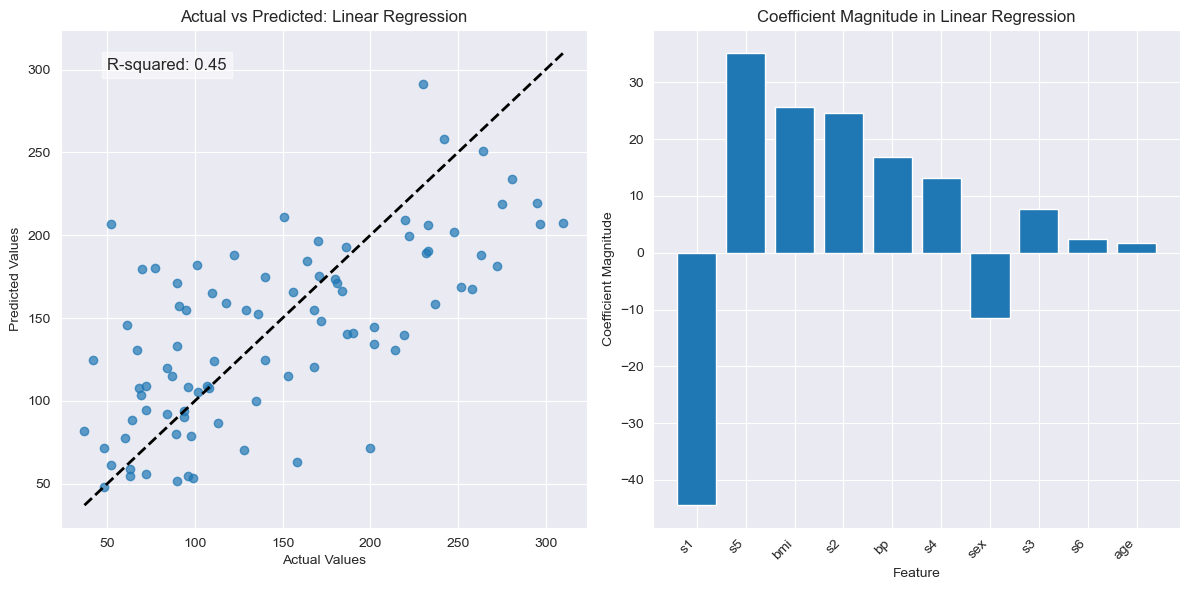

In [7]:
# Create an Actual vs Predicted scatter plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted: Linear Regression')
plt.text(50, 300, f'R-squared: {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)


# Create a bar plot to visualize coefficient magnitudes
plt.subplot(1, 2, 2)
plt.bar(coeff_df['Feature'], coeff_df['Coefficient'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Coefficient Magnitude')
plt.title('Coefficient Magnitude in Linear Regression')
plt.tight_layout()
plt.show()

## From Coefficient Magnitudes to Feature Importance

To move one step further in more robust interpretation of a linear model, we can transform the coefficient magnitude into feature importance by deviding the individual coefiicients by their standard deviation. To calculated the standard deviation of coefficients we need to use a bag of Linear Regression models:

In [8]:
from sklearn.ensemble import BaggingRegressor


# Creating, estimating, and predicting using a bag of 100 Linear regressor models.
n_estimators = 100

# mind that in the newer sklearn versions (the latest) the first input is called 'estimator' instead of 'base_estimator'
bagged_model = BaggingRegressor(base_estimator=LinearRegression(), 
                                n_estimators=n_estimators, 
                                random_state=random_state).fit(X_train_standardized, y_train)

y_pred = bagged_model.predict(X_test_standardized)

# Calculate R-squared value
r2 = r2_score(y_test, y_pred)

/Users/ghaithalseirawan/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [9]:
r2

0.45176272255268746

In [15]:
coefficients = []
for i in range(n_estimators):
    coefficients.append(bagged_model.estimators_[i].coef_)

In [17]:
coefficients = np.vstack(coefficients)
coefficients

array([[ 2.55381672e+00, -9.74363145e+00,  2.27745829e+01,
         1.98759140e+01, -7.15316016e+01,  4.13116072e+01,
         1.96435704e+01,  2.33049228e+01,  4.23035560e+01,
         3.06680543e+00],
       [ 4.11049716e+00, -8.40007788e+00,  2.49238562e+01,
         1.71863119e+01, -4.52544736e+01,  2.82724870e+01,
         4.31275424e+00,  1.32268582e+01,  3.43424627e+01,
        -2.38089127e+00],
       [ 1.54078515e+00, -1.50760096e+01,  2.80216932e+01,
         2.11258737e+01, -1.46412928e+01,  5.97583332e+00,
        -1.05144295e+01,  2.96389887e+00,  2.56381871e+01,
        -6.39669891e-01],
       [ 2.79027903e+00, -6.01658455e+00,  2.46119173e+01,
         1.50446858e+01, -5.78122762e+01,  4.07629339e+01,
         1.65334990e+01,  9.31182174e+00,  3.93182656e+01,
         4.24461815e+00],
       [ 3.28301427e+00, -1.22562264e+01,  2.95923940e+01,
         1.47498015e+01, -6.68388214e+01,  3.20837410e+01,
         2.99970446e+01,  2.63505242e+01,  4.15891371e+01,
         7.

Now, we use the following formula to convert the coefficient magnitude $\beta$ for the $j$ th feature into feature importances: $\frac{\bar{\beta}_j}{SE(\beta_j)}$

In [19]:
feature_importance = np.mean(coefficients, axis=0) / (np.std(coefficients, axis=0)/n_estimators**0.5)

# Create a DataFrame to store the feature importance with their corresponding feature names
fi_df = pd.DataFrame({'Feature': feature_names, 't_stats': feature_importance})

# Sort the DataFrame of feature importance in descending order
fi_df = fi_df.reindex(fi_df['t_stats'].abs().sort_values(ascending=False).index)

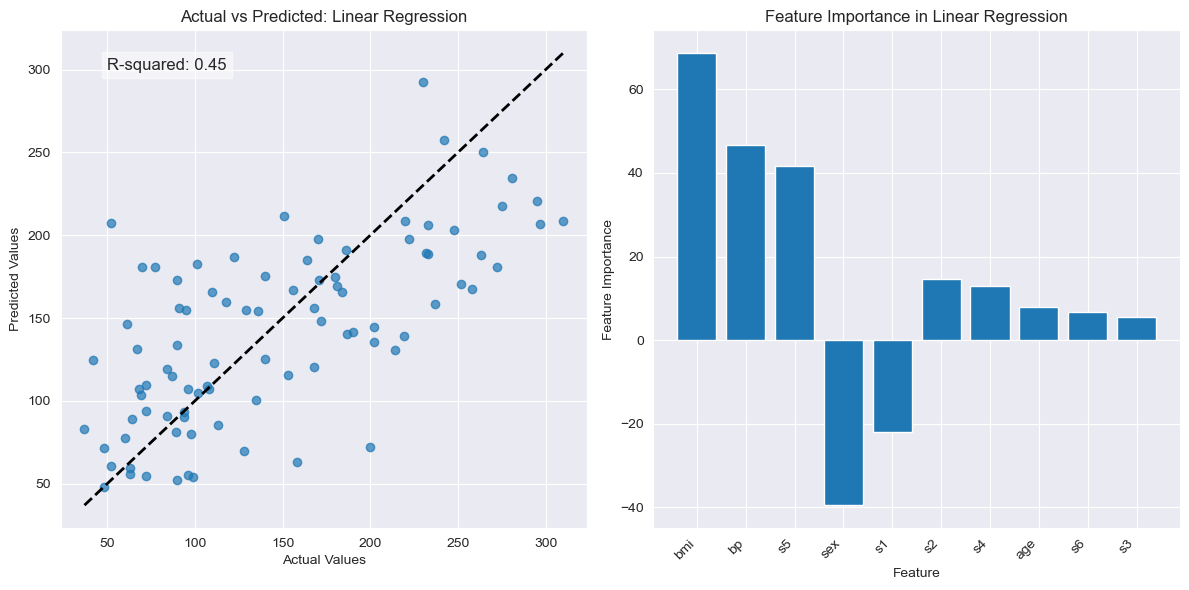

In [20]:
# Create an Actual vs Predicted scatter plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted: Linear Regression')
plt.text(50, 300, f'R-squared: {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)


# Create a bar plot to visualize feature importance
plt.subplot(1, 2, 2)
plt.bar(fi_df['Feature'], fi_df['t_stats'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Linear Regression')
plt.tight_layout()

plt.show()

The effect plot for each feature also can be acalculated by multiplying the $j$ th coefficient by each feature values across all samples $i \in \{0,\dots,n\}$: $w_jx_j^{(i)}$

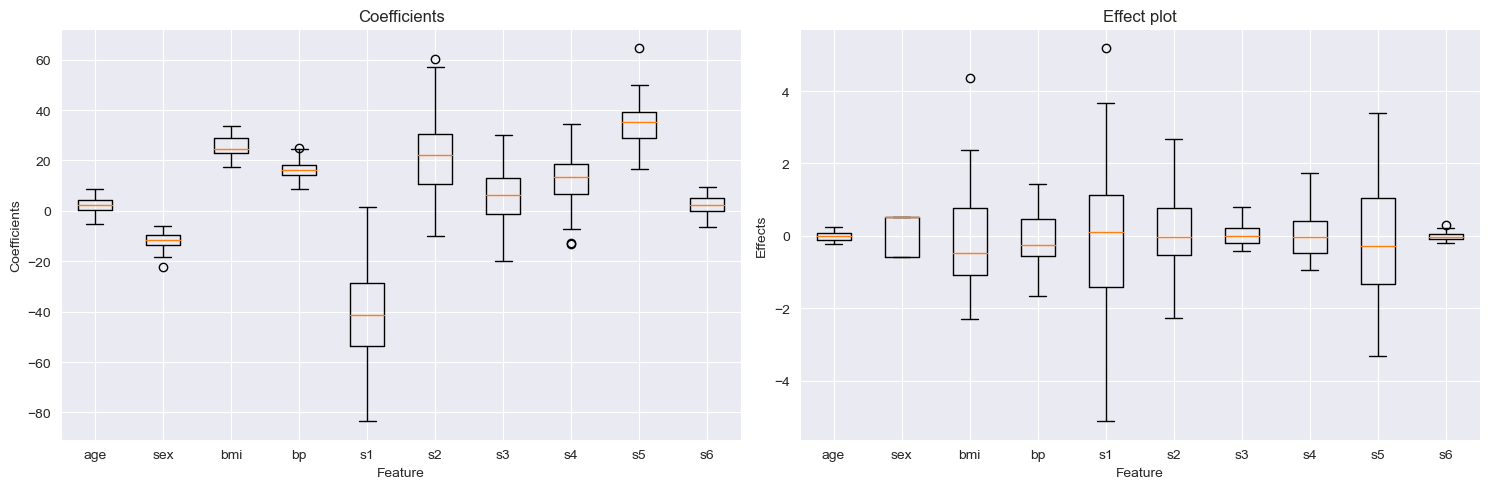

In [13]:
# The distribution of coefficients and effect plot 
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.boxplot(coefficients)
plt.xticks(np.arange(1,len(feature_names)+1), feature_names)
plt.xlabel('Feature')
plt.ylabel('Coefficients')
plt.title('Coefficients')


plt.subplot(1, 2, 2)
plt.boxplot(np.mean(coefficients, axis=0) * X_test)
plt.xticks(np.arange(1,len(feature_names)+1), feature_names)
plt.xlabel('Feature')
plt.ylabel('Effects')
plt.title('Effect plot')
plt.tight_layout()
plt.show()


Let's compare the interpretation results for coefficient magnitude and feature importance methods.


The coefficient magnitudes from the single linear regression model represent the direct impact each feature has on the target variable. This measure fail to capture uncertainty inherent to the modeling and it is sensitive to outliers or anomalies in the training data. On the other hand, the feature importance derived from the bagged ensemble of linear models captures a more robust estimate of each feature's impact, because it factor in variability across multiple models using t-statistics, capturing uncertainty and is more resilient to outliers, offering different insights into feature relevance.


Next we will evaluate the satisfaction of homoscedasticity and multi-collinearity assumtions in this example. I used scatter plot of the error (y-axis) with respect to different features (x-axis) to evaluate the homoscedasticity assumption (the distribution of error around zero should be normal). To check for multi-collinearity, I will plot heatmap of correlation between features.  

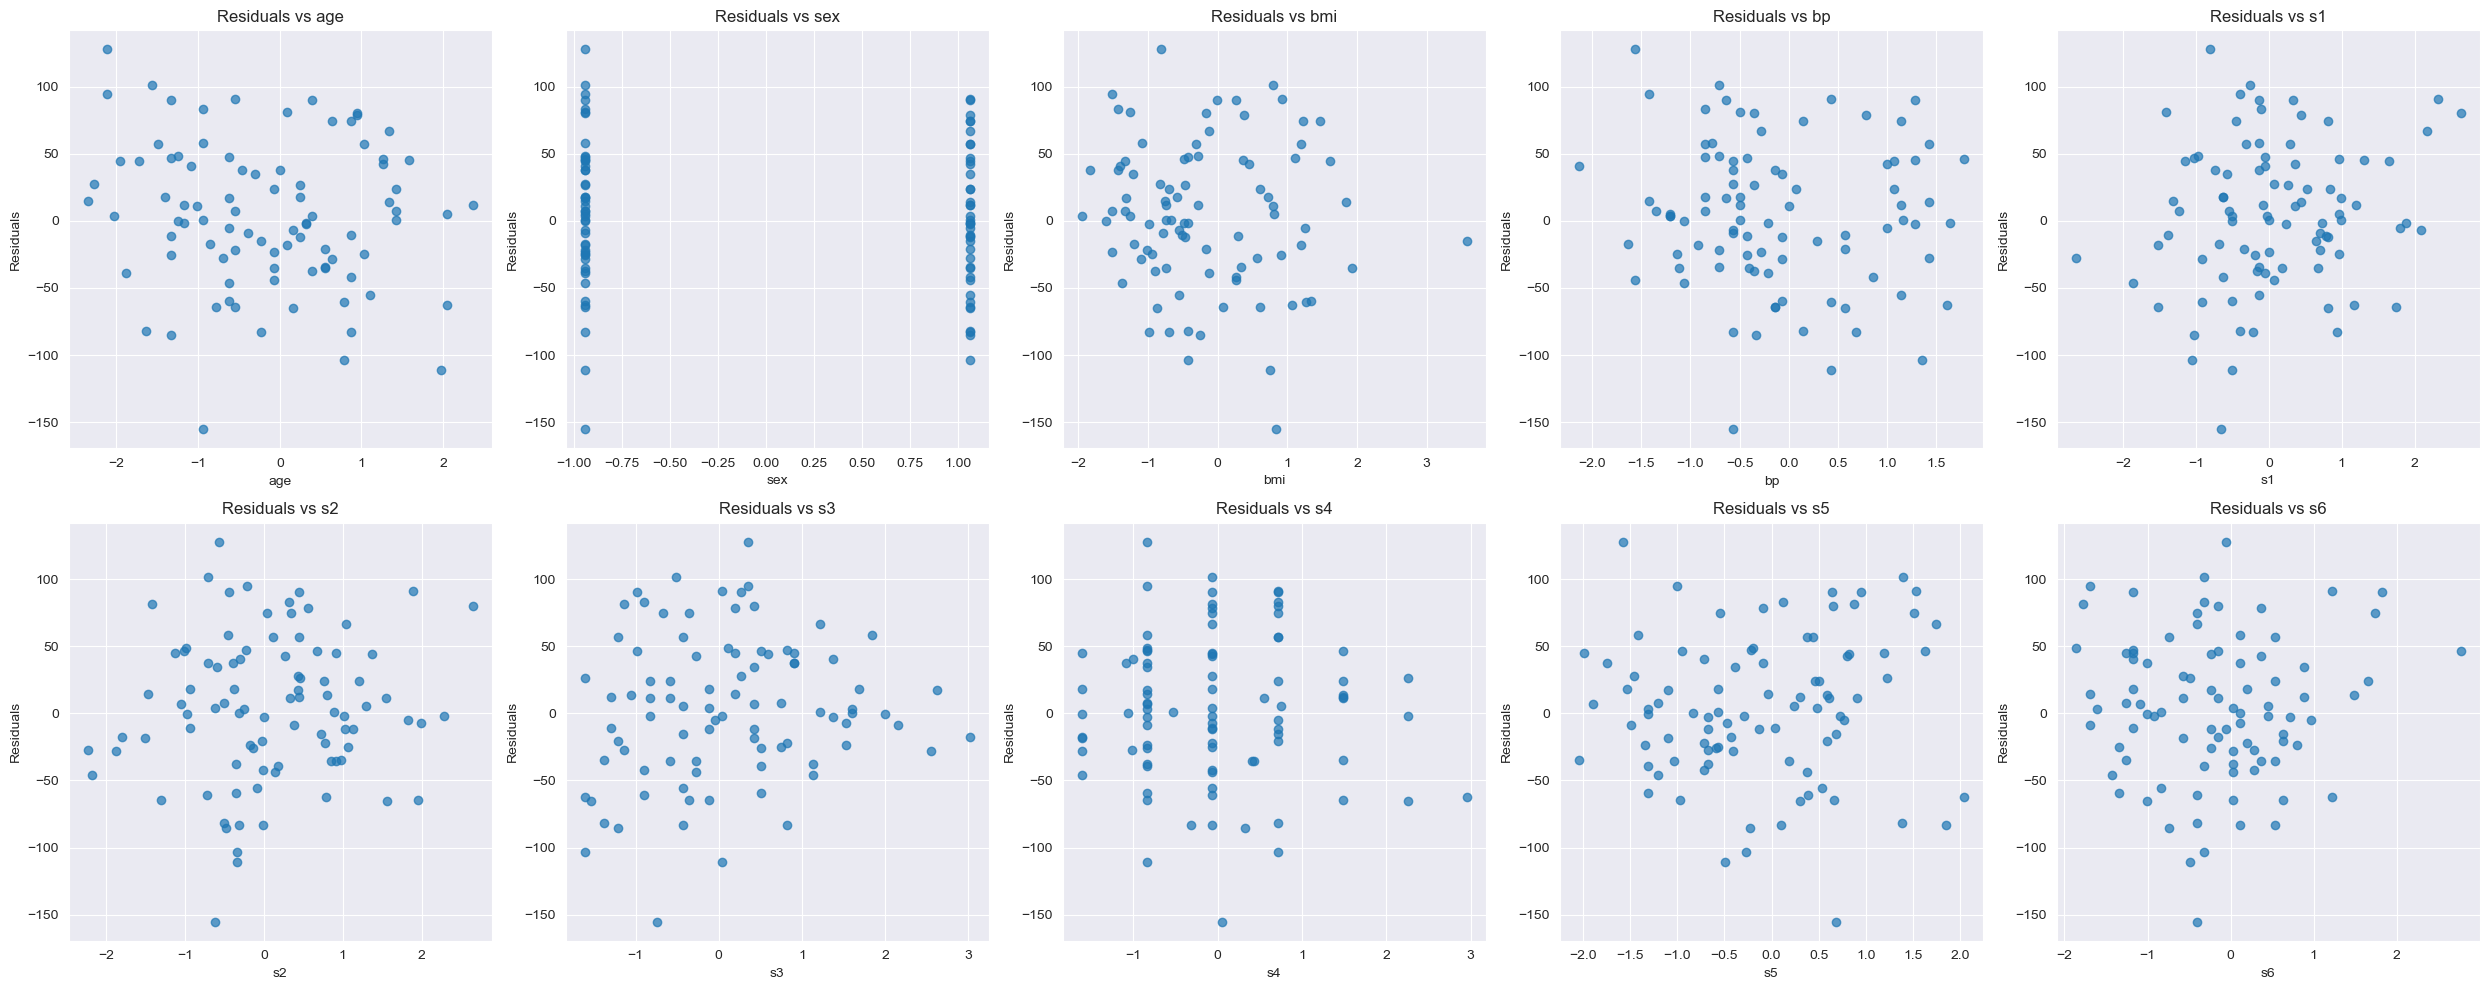

In [14]:
import seaborn as sns

residuals = y_test - y_pred

plt.figure(figsize=(25, 10))
for i, feature in enumerate(diabetes_data.feature_names):
    plt.subplot(2, 5, i+1)
    plt.scatter(X_test_standardized[:, i], residuals, alpha=0.7)
    plt.xlabel(feature)
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs {feature}')
plt.tight_layout()
plt.show()

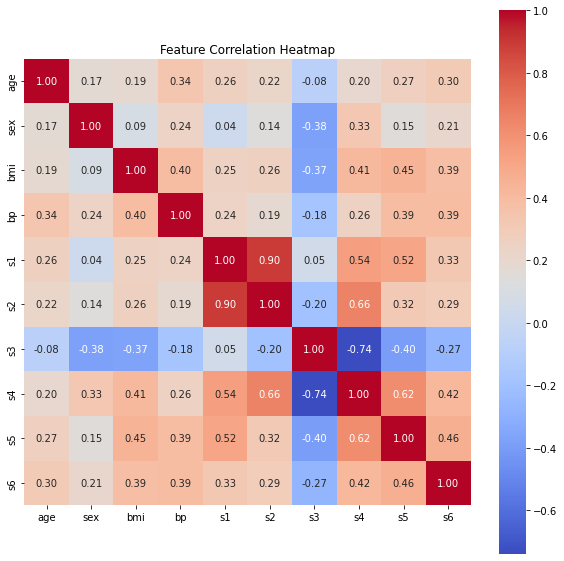

In [20]:
corr = X.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

The spread of residuals in "s4" is not fairly uniform, the homoscedasticity assumption migth be violated.
The feature s4 and s3 are negatively correlated, indicating a possible violation to multi-collinearity assumption.